# Drone doing a full flip 

In [1]:
import numpy as np
import quadrotor
import matplotlib.pyplot as plt

# Function to linearize the dynamics of the drone.
def get_linearlization(z,u):
    A = np.array([[1,quadrotor.DELTA_T,0,0,0,0],[0,1,0,0,-quadrotor.DELTA_T*(u[0]+u[1])*np.cos(z[4])/quadrotor.MASS,0],[0,0,1,quadrotor.DELTA_T,0,0],[0,0,0,1,-quadrotor.DELTA_T*(u[0]+u[1])*np.sin(z[4])/quadrotor.MASS,0],[0,0,0,0,1,quadrotor.DELTA_T],[0,0,0,0,0,1]])
    B = np.array([[0,0],[-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS,-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS,quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA,-quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA]])
    return A,B

In [2]:
# Function which creates state and control costs to promote flipped orientation at t=5 and stabilizes drone at t=10
def cost_function(horizon_length):
    list_of_Q = []
    list_of_R = []
    
    z_target1 = np.array((1.5,0,3,0,np.pi,0)) 
    z_target2 = np.array((3,0,0,0,2*np.pi,0))
    t_lower_target = 0.499
    t_upper_target = 0.501
    
    
    R_tune = 0.1
    
    Q_temp = np.identity(quadrotor.NUMBER_STATES)
    Q1 = 10*Q_temp
    Q2 = 100000*Q_temp
    Q3 = 1*Q_temp
    Q3[4,4] = 10
    Q_end = 100000*Q_temp
    R_temp = R_tune*np.identity(quadrotor.NUMBER_CONTROLS)
    
    for i in range(horizon_length):
        
        if((i<t_lower_target*horizon_length)):
            Q_now = Q1
            
        elif ((i>=t_lower_target*horizon_length)and(i<=t_upper_target*horizon_length)):
            Q_now = Q2    
        else:
            Q_now = Q3
               
        list_of_Q.append(Q_now)
        list_of_R.append(R_temp)
    
    list_of_Q.append(Q_end)
    return list_of_Q,list_of_R,z_target1,z_target2,t_lower_target,t_upper_target


In [3]:
# Function to compute total cost of current trajectory
def compute_cost(z,u,horizon_length):
    total_cost = 0.

    Qn,Rn, z_target1,z_target2, t_lower_target, t_upper_target = cost_function(horizon_length)
    QN = Qn[horizon_length]
    
    for n in range(horizon_length): 
        if(n<t_lower_target*horizon_length):
            total_cost = total_cost + np.transpose(z[:,n])@Qn[n]@(z[:,n]) + np.transpose(u[:,n])@Rn[n]@(u[:,n])
            
        elif ((n>=t_lower_target*horizon_length) and (n<=t_upper_target*horizon_length)):
            total_cost = total_cost + np.transpose(z[:,n]-z_target1)@Qn[n]@(z[:,n]-z_target1) + np.transpose(u[:,n])@Rn[n]@(u[:,n])

        else:
            total_cost = total_cost + np.transpose(z[:,n]-z_target2)@Qn[n]@(z[:,n]-z_target2) + np.transpose(u[:,n])@Rn[n]@(u[:,n])
    #print("total cost = ",total_cost[0])    
    total_cost = total_cost + np.transpose(z[:,horizon_length]-z_target2)@QN@(z[:,horizon_length]-z_target2)
                                                                                  
    #print("total cost = ",total_cost)
    return total_cost

In [4]:
#Function to return hessian and gradients of cost (Quadratic approximation of the cost)
def get_quadratic_approximation_cost(z, u, horizon_length):
    
    Qn_orig, Rn_orig, z_target1,z_target2, t_lower_target, t_upper_target = cost_function(horizon_length)
    
    QN_orig = Qn_orig[horizon_length]
    
    qN = 2*QN_orig@(z[:,horizon_length]-z_target2)
    QN = 2*QN_orig
    
    Qn = []
    Rn = []
    qn = []
    rn = []
    for j in range(horizon_length):
        if((j<t_lower_target*horizon_length)):
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])
            qn.append(2*Qn_orig[j]@z[:,j])
            rn.append(2*Rn_orig[j]@(u[:,j])) 
            
        elif((j>=t_lower_target*horizon_length) and (j<=t_upper_target*horizon_length)):
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])

            qn.append(2*Qn_orig[j]@(z[:,j]-z_target1))
            rn.append(2*Rn_orig[j]@(u[:,j]))
        
        else:
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])
  
            qn.append(2*Qn_orig[j]@(z[:,j]-z_target2))
            rn.append(2*Rn_orig[j]@(u[:,j]))
    
    Qn.append(QN)
    qn.append(qN)
    return Qn,Rn,qn,rn

In [5]:
# Solve LQR equations for current trajectory
def solve_Riccati_recursion(Q, R,q,r,z_traj, u_traj, N):

    
    k=N-1
    K_gains = []
    k_feedforward = []
    
    P_prev=Q[N]
    p_prev=q[N]
    
    while(k>=0):
        
        A,B = get_linearlization(z_traj[:,k],u_traj[:,k])
        
        Kn = -np.linalg.inv(B.transpose()@P_prev@B+R[k])@B.transpose()@P_prev@A
        
        Pn = Q[k]+A.transpose()@P_prev@A + A.transpose()@P_prev@B@Kn
        
        kn = -np.linalg.inv(B.transpose()@P_prev@B+R[k])@(B.transpose()@p_prev+r[k])
        
        pn = q[k]+A.transpose()@p_prev + A.transpose()@P_prev@B@kn
        
        K_gains.append(Kn)
        k_feedforward.append(kn)
        
        P_prev = Pn
        p_prev = pn
        
        k=k-1
        
    
    K_gains.reverse()
    k_feedforward.reverse()
    
    return K_gains, k_feedforward

In [6]:
def integrate_dynamics(z0,u_guess,horizon_length):
    
    z_guess=np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
    z_guess[:,0] = z0
    for i1 in range(horizon_length):
        z_guess[:,i1+1] = quadrotor.get_next_state(z_guess[:,i1], u_guess[:,i1])
    return z_guess

In [7]:
# Integrate dynamics
def forward_dynamics(z0,K_g,k_g,horizon_length,alpha):
    
    z=np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    for i2 in range(horizon_length):
        u[:,i2] = u[:,i2] + K_gains_curr[i2]@(z_curr[:,i2]-z_guess[:,i2])+k_feedforward_curr[i2]
        z[:,i2+1] = quadrotor.get_next_state(z[:,i2], u[:,i2])
    return z_guess, u_guess

In [8]:
# iLQR algorithm implementation
def solve_iLQR(threshold = 0.0001):
    
    
    #initial guess
    
    T = 10 #seconds
    horizon_length = int(T/quadrotor.DELTA_T)
    
    # Initial guess u =mg/2
    u_guess = np.stack((np.repeat([quadrotor.MASS*quadrotor.GRAVITY/2],horizon_length),np.repeat([quadrotor.MASS*quadrotor.GRAVITY/2],horizon_length)))

    #integrate the system to find z_guess
    z0 = np.zeros([quadrotor.NUMBER_STATES])
    
    z_guess = integrate_dynamics(z0,u_guess,horizon_length)
    
    # Save initial guess
    u_initial = u_guess
    z_initial = z_guess
    
    # Initialize prev cost and current cost
    J_prev = compute_cost(z_guess,u_guess,horizon_length)
    thresh_last =1000
    
    while(thresh_last > threshold):
        
        #Backward pass, each return value is a list
        Qn_curr,Rn_curr,qn_curr,rn_curr = get_quadratic_approximation_cost(z_guess, u_guess, horizon_length)
        
        # Linearize at z_guess[t] and u_guess[t]
        K_gains_curr, k_feedforward_curr = solve_Riccati_recursion(Qn_curr,Rn_curr,qn_curr,rn_curr,z_guess, u_guess, horizon_length)

        #Forward pass
        
        #Initialize cost and trajectories
        z_curr = np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
        u_curr = np.empty([quadrotor.NUMBER_CONTROLS, horizon_length])
        z_curr[:,0] = np.zeros([quadrotor.NUMBER_STATES])
        
        for o in range(horizon_length):
            u_curr[:,o] = u_guess[:,o] + K_gains_curr[o]@(z_curr[:,o]-z_guess[:,o])+k_feedforward_curr[o]

            z_curr[:,o+1] = quadrotor.get_next_state(z_curr[:,o],u_curr[:,o])
        
        J_curr = compute_cost(z_curr,u_curr,horizon_length)

        # We now have new states z_curr
        #line search
        if(J_curr>=J_prev):
            alpha = 1
            while(J_curr>=J_prev and alpha>0.01):
                
                z_line = np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
                u_line = np.empty([quadrotor.NUMBER_CONTROLS, horizon_length])
                
                z_line[:,0] = np.zeros([quadrotor.NUMBER_STATES])
                
                for l in range(horizon_length):
                    u_line[:,l] = u_guess[:,l] + K_gains_curr[l]@(z_line[:,l]-z_guess[:,l])+alpha*k_feedforward_curr[l]
                    z_line[:,l+1] = quadrotor.get_next_state(z_line[:,l],u_line[:,l])
                
                J_curr = compute_cost(z_line,u_line,horizon_length)
                if(J_curr<J_prev):
                    # Better trajectory found
                    z_guess = z_line
                    u_guess = u_line
                    thresh_last = J_prev - J_curr
                    J_prev = J_curr
                    break
                else:    
                    # Re-do line search
                    alpha = alpha/2
        else:
            z_guess = z_curr
            u_guess = u_curr
            thresh_last = J_prev - J_curr
            J_prev = J_curr

    return z_initial,u_initial,z_guess, u_guess

In [9]:
z_i,u_i,z_f,u_f=solve_iLQR()
T =10
horizon_length = int(T/quadrotor.DELTA_T)
time = np.arange(0.,(T+quadrotor.DELTA_T), quadrotor.DELTA_T)

# Initial trajectory

Text(0.5, 0, 'Time [s]')

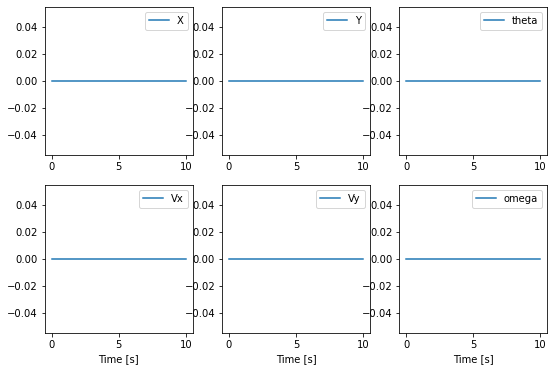

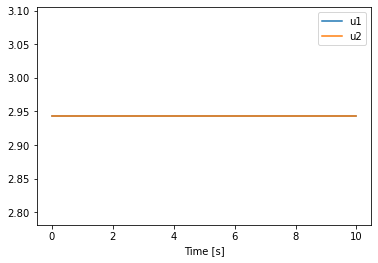

In [10]:
t, state_list, u = time, z_i, u_i
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Final trajectories

Text(0.5, 0, 'Time [s]')

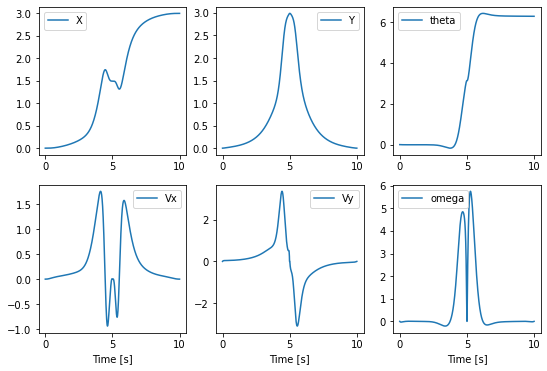

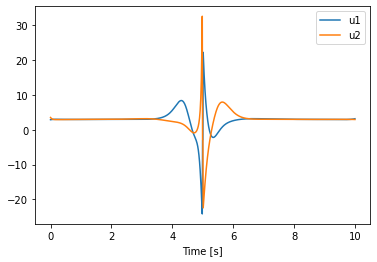

In [11]:
t, state_list, u = time, z_f, u_f
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Animation

In [12]:
quadrotor.animate_robot(z_f,u_f)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAVvRtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA2OZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0agX3rQrxAFVDm
jgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzzgStuUpMltOrgd3xiXeRy
NijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6aV0xf5e1Y3eMSRhlnOEg
5t6laqwn4ehgEZ2RN/0//u4oRdcLYjvj7rDRnH5cb7OVcVeDDGblDP4oiq80WQOVQ/kvRcX6GntS
Tyf2SkA1tyCNIyktbublNs2xhPCwz3kf2rP4S8jvTxqEdS7q8r7UnnwkyNZtsidmfggEoAALuDpT
UqgO2Nyc/nyo2P8mgMLl9W2v4DablAAh40KXLQOiQA0eTXhSNU48dP9tF0wwuFwd4UGlWZaNRk+c
PEQ/GeZ0B3tBqqih8K40vtZGgyZSX/Cllsgqdg87QMUDgaJ7ASAyDb/CkU0nALDfO+cnRvfZl6Sl
9fLa1LK9B3Q1wTbHr5w1s3/m8ux2rJaVHDZCUV/y38xSEO80k+48n4ueT6r6VDh4ujgolzbZLj9d
/49jd6q5J0Apc+ZRvsR0TaOEO5b8o0ujSeIOIgkhOahi4LpV4bVwK7he/ZWo2EuAlsgT8wA30ZbL
wxWrckoxjTmGltHrkOT94ux0DHMECvahXEYWRP8+EZ9m2FtbGM87U5PlU64eUabBTV3Wnsn0B/2R
juUaQEeRisjjK6w9xhThdeSIEFeZ92nFAAADALUJmMzIrlzbZgF1CUqCXUqRwKxHFQu+PTuUm9oT
/Vy3SzoQFPDMT5Ra6nIZNf287fjlo2z/A1D/hXVu69U4jR1B5LgHGGFfma/S8zYm00FY9HJpLUQI
o8vr8x2jOojPA/pyd34cdKKxgRl4bSAipTKY9OevUjE/+kGCaCbwEVK1ZNMeMszFDrRxiXUrh7Wb
eELWicEcHDHF9aCFrlQXQgwzuRotpH7hqg8AMClCEjNHTuf1cVlp78zbFX18BWbBnDYyKYYb6z4D
I7n28etNoeKwPu74SQDdSX/pUDTBJBfj2EmBdn9b2VbHKwoW3v1fsf/IB9Mj+RHjncXc42nxoD4B
R0jtBsp1SSimoT7XFTcuW/CqTgAW1jmNQGw0M3+AB50IvXqyLHRJwmsD/JDqBUInDUUexPX95gu7
HCfCrYWMbYoY44neT8fmFvbJSBwDLB2MPI01U//7laNfFPAYozf1zqHcqw0bcEpH/Z/lmb3g1cxx
K5uu15Wgd76WogCYZkIMvQo2OEY0JaGlYQzDymyxlYiecuBQO2/a2D+3FTTQSeGjP+fIG+1CLxtK
xGeTNF8VgLWfhssjk9enRJLTUXPqTPf7XvgiNewYe3Ki6u93g+xQXNwAdCL+TUbtIRXoKW0DVmOa
y10svjSAqVqjB/4/Zv3sutkkql6zfsu02zBzr4qvc0en/dN+V2dN1MWv1TaE1gkHJIrSrFNpoPK5
quDLrJ/a1c02KjAAAAMAACj2Ox8cNjh/BA2FAm3s99sGT8sE6V9pM5tizhpDbbZKwhxQUAFTu1U+
XY8nKyv/wXEwpkvWM+3vFZ7C9BW44Eo4mRV2J7UoiK3CgHxtqfBuMh/trPQ78dSQihtaept4xFWW
sk03oSTfaB3NEYuuWRIOgL/MVZWY79E2mLsjAeto/GBnxDRolmtK7qsaGc2/IEgGVOUL+tRZ3BvB
Li+l3/oLCb1LuMzE6XrW9pt2Hb6Z0ZbhVg6HPFC2t5tlZ5e22RNDhd4jrrJSsdDit1jt9Pj20Vkj
PW8KaniIk/5F+rpkWHl+sztqWg9HeA3sUKvqLWV5yu0QogX4hFk1T8DSNt6fnmZ0qsnVy2EpQLgC
tuCBdfZ6h+7TVBxCnLkOhXatrBIBJIFGE7DEdl36DB5whrWulWiQKWzMHh61N383gUvxegaf8Kct
3A0Z3LXKc2n6oG8hnI6Itu5JvxeJIkZJ3gEm0qKEbP8f8d5fUYdA0QD33rLryeXP7WsKyi3hIp3h
mI2BdRZrZSfkieLw7ZYmfP1xnYXxfhv7p/s6zrm5gPE3mZmPqHfg4gRdXCH5RC/t9KCQjp4TP3/G
ngpE2z+khqc7B3WUUxQACTp0ZpLtoEYAAAbhSOpIrYANF56BNIMWQL5lBN4v/84Qzz86a2nV+7nB
jcmj496vD/E+9Qy3RsmakmTbWGLreb0+hK+sDsB47wosB5i5mlh+e9EWXEfP91uGH5GqXqJyihAG
121hXKFUdF0abnCWR1Ye/n+/+YcKEfCk/b+1u2Oqda2VyCqZak28aDApyIY0oJiCJqW1vZsn51Xb
2Gl+k3+cjewodWvHnjWIfWTHDy7uiSTvSl8Vus4cLH1zlrPvvNWPI7SJIJypGNC7MMN53Zo/G0mn
w3rLSlXMxR9vetcQKV7y1W02FmYKrgQuxF8cOvVicbXUIIU3jNrTi2kBjHKfk83XBh/8zafczoSF
IaLGG12AtKdomZAAAAMAAAfyOUn5yoq3fCG9cV3JTi6wJ/2H/oX6ictWpam/ZjnZij5QOwi921Ma
99ve/9wZWJTs8NaaGjEBQrMB2HUesKOhPovqM3szwzEwDk9qbsqalqydHSF98aM9w0mVNIljisNd
X19YoAEEglIxeopjz0n5t/uHRXvGpPvWz0ysfUslxfmxmXNx7f7QeRohYTjLX4cARDFWc5y8w9Ma
hpypf+aMXjFtkOtkkY0p+/vWZ98SIV/RQv5hEMIqSqEg2yI+hmgERRi6/LMV0DMi2rzybQYuTWPi
3tXSCUEeoz+8sNx1i0UYVzQWiAf+mtivMAAAAwBOQGBEuQ+jLqUOWlxZhdQwpzJrhJf/Ayz+p8gB
9LSCgfcDHNU4rhww+JE5J